# Import Dependencies and CSV Files read in

In [95]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import gmaps
import os
from api_keys import g_key

file_to_load = "../airbnb/AirBnB 2019/calendar_2019.csv"
list_to_load = "../airbnb/AirBnB 2019/listings_2019.csv"

cal_2019 = pd.read_csv(file_to_load)
list_2019 = pd.read_csv(list_to_load, low_memory = False)

file_to_load = "../airbnb/AirBnB 2020/calendar_2020.csv"
cal_2020 = pd.read_csv(file_to_load)

file_to_load = "../airbnb/AirBnB 2020/listings_2020.csv"
list_2020 = pd.read_csv(file_to_load)

In [103]:
# Reduced initial data down to only valid calumns we were using for project
# Renamed id column to listing_id for consistency across datasets

list_2019 = list_2019[['id','name','host_response_time','host_response_rate','host_is_superhost',
                           'city','latitude','longitude','property_type','room_type',
                           'accommodates','bathrooms','bedrooms','beds', 'amenities','price',
                           'security_deposit', 'has_availability',
                           'availability_365', 'number_of_reviews','review_scores_rating',
                           'review_scores_accuracy', 'review_scores_cleanliness',
                           'review_scores_checkin', 'review_scores_communication',
                           'review_scores_location', 'review_scores_value','reviews_per_month']]
list_2019 = list_2019.rename(columns = {'id': 'listing_id'})

In [104]:
# Reduced initial data down to only valid calumns we were using for project
# Renamed id column and neighbourhood_cleansed to listing_id and city for consistency across datasets

list_2020 = list_2020[['id','name','host_response_time','host_response_rate','host_is_superhost',
                       'neighbourhood_cleansed',
                       'latitude','longitude','property_type','room_type',
                       'accommodates','bathrooms','bedrooms','beds', 'amenities','price', 'has_availability',
                       'availability_365', 'number_of_reviews','review_scores_rating',
                       'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value','reviews_per_month']]
list_2020 = list_2020.rename(columns = {'id': 'listing_id','neighbourhood_cleansed':'city'})

# Which Melbourne suburb has the most listings on AirBnB?

## How were these listings affected in 2020 vs 2019 data?

In [105]:
neighborhood_count19 = pd.DataFrame(list_2019['city'].value_counts())
neighborhood_count20 = pd.DataFrame(list_2020['city'].value_counts())
neighborhood_count20 = pd.merge(neighborhood_count19, neighborhood_count20, left_index = True, right_index = True, how = 'outer', suffixes = ('_2019','_2020'))
neighborhood_count20 = neighborhood_count20.sort_values(by = 'city_2019', ascending = False)
neighborhood_count20 = neighborhood_count20.rename(columns = {'city_2019': '2019 Listings', 'city_2020': '2020 Listings'})
neighborhood_count20['Change in Listings'] = neighborhood_count20['2020 Listings'] - neighborhood_count20['2019 Listings']
neighborhood_count20.head()

,2019 Listings,2020 Listings,Change in Listings
Melbourne,7368,6174,-1194
Port Phillip,2808,2498,-310
Yarra,2049,1578,-471
Stonnington,1621,1369,-252
Moreland,967,863,-104


In [106]:
neighborhood_count20.sum()

2019 Listings         22895
2020 Listings         20420
Change in Listings    -2475
dtype: int64

# Plot change in listings for each suburb

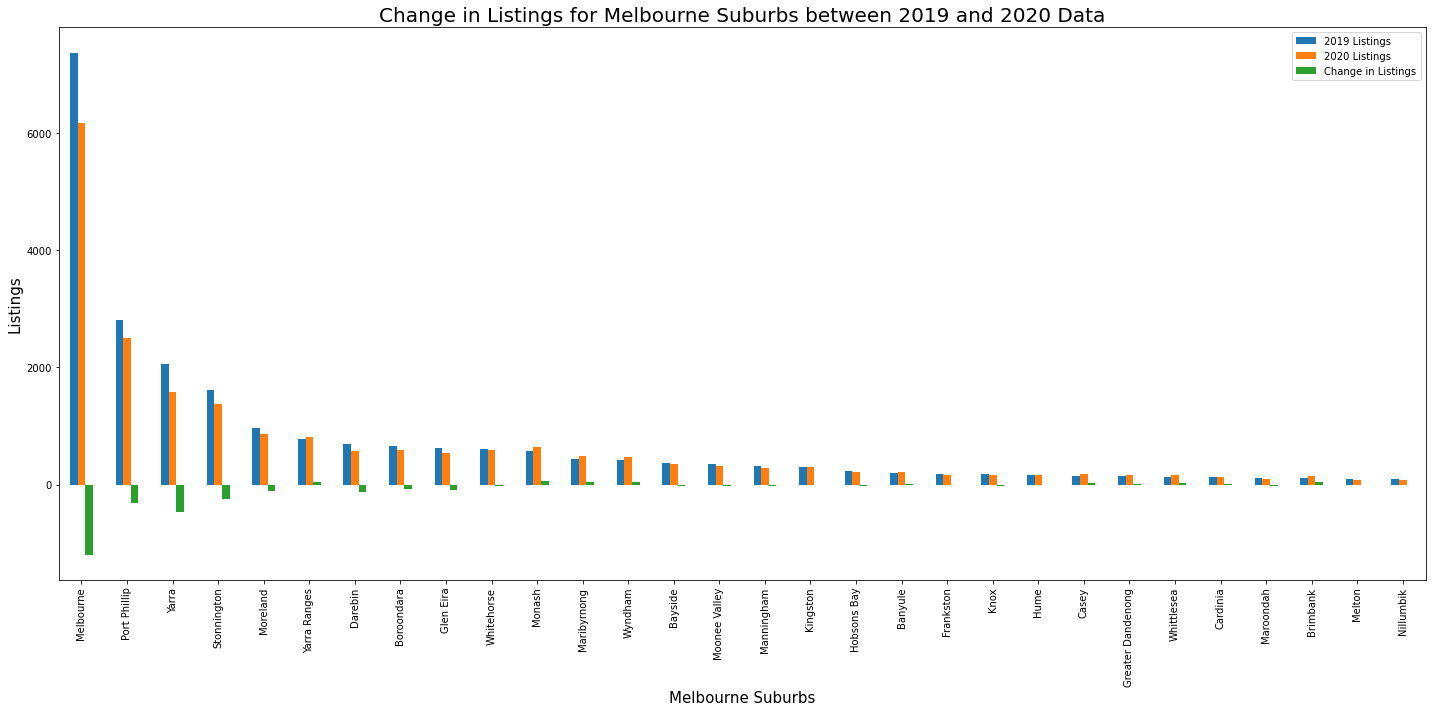

In [113]:
neighborhood_count20.plot(kind = 'bar', y = ['2019 Listings', '2020 Listings', 'Change in Listings'], 
                          align = 'center', figsize = (20,10))
plt.xlabel('Melbourne Suburbs', fontsize = 15)
plt.ylabel('Listings', fontsize = 15)
plt.title('Change in Listings for Melbourne Suburbs between 2019 and 2020 Data', fontsize = 20)
plt.tight_layout()
plt.savefig('output_files/listings_bar.png')

# Compare days which were booked across each suburb, average and median for the data sets

In [57]:
list_2019['Booked_2019'] = 365 - list_2019['availability_365']
neighborhood_book2019 = list_2019.groupby('city').mean()
total_days = pd.DataFrame(neighborhood_book2019['Booked_2019'])
neighborhood_book2019 = list_2019.groupby('city').median()
total_days['Median Days Booked 2019'] = neighborhood_book2019['Booked_2019']



list_2020['Booked_2020'] = 365 - list_2020['availability_365']
neighborhood_book20 = list_2020.groupby('city').mean()
total_days20 = pd.DataFrame(neighborhood_book20['Booked_2020'])
neighborhood_book20 = list_2020.groupby('city').median()
total_days20['Median Days Booked 2020'] = neighborhood_book20['Booked_2020']
total_days = pd.DataFrame(pd.merge(total_days, total_days20, left_index = True, right_index = True, how = 'outer'))
total_days = total_days.sort_values(by = 'Booked_2019', ascending = False)
total_days = total_days.rename(columns = {'Booked_2019': 'Average Days Booked 2019','Booked_2020':'Average Days Booked 2020'})
total_days = total_days.reset_index(inplace = False)
total_days.head()

,city,Average Days Booked 2019,Median Days Booked 2019,Average Days Booked 2020,Median Days Booked 2020
0,Moreland,265.514995,320.0,252.209733,287.0
1,Yarra,265.232796,327.0,253.365019,341.0
2,Darebin,259.992837,323.0,256.111111,333.0
3,Melbourne,242.376629,289.0,231.425656,275.0
4,Stonnington,239.495373,294.0,235.598977,278.0


# Heatmaps of listings location based on price

In [58]:
gmaps.configure(api_key=g_key)
fig2019 = gmaps.figure()
coord2019 = list_2019[['latitude','longitude']]
price = list_2019['price']
heat_layer = gmaps.heatmap_layer(coord2019, weights = price, dissipating = False, max_intensity = max(price), point_radius=0.009)
fig2019.add_layer(heat_layer)
fig2019

Figure(layout=FigureLayout(height='420px'))

In [59]:
# Required code to remove a dollar sign from the price in 2020 data

gmaps.configure(api_key=g_key)
fig2020 = gmaps.figure()
coord2020 = list_2020[['latitude','longitude']]
list_2020['price'] = list_2020['price'].replace('[\$,]', '', regex=True).astype(float)
price = list_2020['price']
heat_layer = gmaps.heatmap_layer(coord2020, weights = price, dissipating = False, max_intensity = max(price), point_radius=0.009)
fig2020.add_layer(heat_layer)
fig2020

Figure(layout=FigureLayout(height='420px'))

# Separating date data into 3 columns for analysis

In [115]:
cal_2019['date'] = pd.to_datetime(cal_2019['date'])
cal_2019['day'] = cal_2019['date'].dt.day
cal_2019['month'] = cal_2019['date'].dt.month
cal_2019['year'] = cal_2019['date'].dt.year

In [116]:
cal_2020['date'] = pd.to_datetime(cal_2020['date'])
cal_2020['day'] = cal_2020['date'].dt.day
cal_2020['month'] = cal_2020['date'].dt.month
cal_2020['year'] = cal_2020['date'].dt.year

In [117]:
sub_cal_2020 = pd.merge(cal_2020[['listing_id','date','available','day','month','year']],
                        list_2020[['listing_id','city']], on = 'listing_id',how = 'outer')
sub_cal_2020 = sub_cal_2020.loc[sub_cal_2020['available'] == 'f']
sub_cal_2020.head()

,listing_id,date,available,day,month,year,city
151,875444,2021-01-18,f,18,1,2021,Port Phillip
152,875444,2021-01-19,f,19,1,2021,Port Phillip
153,875444,2021-01-20,f,20,1,2021,Port Phillip
154,875444,2021-01-21,f,21,1,2021,Port Phillip
155,875444,2021-01-22,f,22,1,2021,Port Phillip


In [118]:
sub_cal_2019 = pd.merge(cal_2019[['listing_id','date','available','day','month','year']],
                        list_2019[['listing_id','city']], on = 'listing_id',how = 'outer')
sub_cal_2019 = sub_cal_2019.loc[sub_cal_2019['available'] == 'f']
sub_cal_2019.head()

,listing_id,date,available,day,month,year,city
0,136510,2019-10-15,f,15,10,2019,Melbourne
1,136510,2019-10-14,f,14,10,2019,Melbourne
2,136510,2019-10-13,f,13,10,2019,Melbourne
3,136510,2019-10-12,f,12,10,2019,Melbourne
4,136510,2019-10-11,f,11,10,2019,Melbourne


# Look at the top 5 suburbs for average days booked and look for trends in their busy months

In [91]:
months = list(sub_cal_2019['month'].unique())
years = list(sub_cal_2019['year'].unique())
cities = list(total_days['city'].head(5))

rows_list = []
for city in cities:
    for year in years:
        for month in months:
            city_dict = {}
            df_city = sub_cal_2019.loc[(sub_cal_2019['city'] == city) & 
                                       (sub_cal_2019['available'] == 'f') & 
                                       (sub_cal_2019['month']==month) & 
                                       (sub_cal_2019['year']==year)]
            list_count = df_city['listing_id'].nunique()
            book_nights = df_city['day'].count()
            
            if list_count > 0:
                book_ave = round(book_nights/list_count,2)
                city_dict['City'] = city
                city_dict['Year'] = year
                city_dict['Month'] = month
                city_dict['Listings With Bookings'] = list_count
                city_dict['Total of Nightly Bookings'] = book_nights
                city_dict['Average Nights Booked at Listing'] = book_ave
                rows_list.append(city_dict)
                
busy_month = pd.DataFrame(rows_list)
busy_month19 = busy_month.sort_values(['Year','Month'],ascending = True)

In [92]:
busy_month19 = busy_month19.reset_index(drop=True)
busy_month19.head(10)

,City,Year,Month,Listings Available,Total of Nightly Bookings,Average Nights Booked at Listing
0,Moreland,2018,12,942,17516,18.59
1,Yarra,2018,12,2008,39544,19.69
2,Darebin,2018,12,664,13389,20.16
3,Melbourne,2018,12,7166,123712,17.26
4,Stonnington,2018,12,1574,28456,18.08
5,Moreland,2019,1,782,19207,24.56
6,Yarra,2019,1,1831,44572,24.34
7,Darebin,2019,1,571,14275,25.00
8,Melbourne,2019,1,6355,129053,20.31
9,Stonnington,2019,1,1316,30912,23.49


In [119]:
months = list(cal_2020['month'].unique())
years = list(cal_2020['year'].unique())
cities = list(total_days['city'].head(5))

rows_list = []
for city in cities:
    for year in years:
        for month in months:
            city_dict = {}
            df_city = sub_cal_2020.loc[(sub_cal_2020['city'] == city) & 
                                       (sub_cal_2020['available'] == 'f') & 
                                       (sub_cal_2020['month']==month) & 
                                       (sub_cal_2020['year']==year)]
        
            list_count = df_city['listing_id'].nunique()
            book_nights = df_city['day'].count()
            
            if list_count > 0:
                book_ave = round(book_nights/list_count,2)
                city_dict['City'] = city
                city_dict['Year'] = year
                city_dict['Month'] = month
                city_dict['Listings With Bookings'] = list_count
                city_dict['Total of Nightly Bookings'] = book_nights
                city_dict['Average Nights Booked at Listing'] = book_ave
                rows_list.append(city_dict)
busy_month = pd.DataFrame(rows_list)
busy_month20 = busy_month.sort_values(['Year','Month'],ascending = True)

In [120]:
busy_month20 = busy_month20.reset_index(drop = True)
busy_month20.head(10)

,City,Year,Month,Listings With Bookings,Total of Nightly Bookings,Average Nights Booked at Listing
0,Moreland,2020,8,745,7003,9.40
1,Yarra,2020,8,1327,12958,9.76
2,Darebin,2020,8,491,4749,9.67
3,Melbourne,2020,8,4801,45216,9.42
4,Stonnington,2020,8,1119,10239,9.15
5,Moreland,2020,9,569,15800,27.77
6,Yarra,2020,9,1068,29541,27.66
7,Darebin,2020,9,396,11196,28.27
8,Melbourne,2020,9,3696,99316,26.87
9,Stonnington,2020,9,836,22695,27.15


### Plotting number of room types between 2019 vs 2020

In [63]:
# grouping by room type to get the count of number of room types in 2019
room_group2019_count = list_2019.groupby('room_type')
room_group2019_count = room_group2019_count['listing_id'].count().reset_index()

hotel_row_2019 = {'room_type':'Hotel Room', 'listing_id':0}

room_group2019_count = room_group2019_count.append(hotel_row_2019, ignore_index=True)
room_group2019_count = room_group2019_count.sort_values('room_type')
room_group2019_count

,room_type,listing_id
0,Entire home/apt,14379
3,Hotel Room,0
1,Private room,8116
2,Shared room,400


In [64]:
# grouping by room type to get the count of number of room types in 2020
room_group2020_count = list_2020.groupby('room_type')
room_group2020_count = room_group2020_count['listing_id'].count().reset_index()

room_group2020_count = room_group2020_count.sort_values('room_type')
room_group2020_count

,room_type,listing_id
0,Entire home/apt,12613
1,Hotel room,227
2,Private room,7161
3,Shared room,419


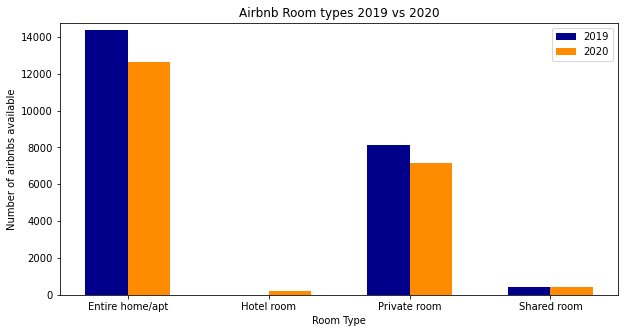

In [65]:
# Plotting the room types for 2019 vs 2020

# Numbers of pairs of bars
N = 4

# Position of bars on x-axis
position = np.arange(N)

plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(position, room_group2019_count['listing_id'] , width, label='2019', color='darkblue')
plt.bar(position + width, room_group2020_count['listing_id'], width, label='2020', color='darkorange')

plt.xlabel('Room Type')
plt.ylabel('Number of airbnbs available')
plt.title('Airbnb Room types 2019 vs 2020')

plt.xticks(position + width / 2, room_group2020_count['room_type'])
plt.ylim(0, 14750)

plt.legend(loc='best')
plt.savefig('output_files/Roomtypes.png')
plt.show()

### Plotting Price of room type in suburbs for 2019 vs 2020

In [66]:
# Room Type and Price - 2019
# groupby city and room_type to get median price
room_city_group2019 = list_2019.groupby(['city', 'room_type'])['price'].median().reset_index()
room_city_group2019

,city,room_type,price
0,Banyule,Entire home/apt,120.0
1,Banyule,Private room,53.0
2,Banyule,Shared room,50.0
3,Bayside,Entire home/apt,199.0
4,Bayside,Private room,71.0
...,...,...,...
83,Yarra,Private room,65.0
84,Yarra,Shared room,29.0
85,Yarra Ranges,Entire home/apt,220.0
86,Yarra Ranges,Private room,117.0


In [67]:
# Room Type and Price - 2020
# groupby neighbourhood cleansed and room_type to get median price
list_2020['price'] = list_2020['price'].replace('[$,]', '', regex=True).astype(float)
room_city_group2020 = list_2020.groupby(['city', 'room_type'])['price'].median().reset_index()
room_city_group2020

,city,room_type,price
0,Banyule,Entire home/apt,125.0
1,Banyule,Private room,45.0
2,Banyule,Shared room,50.0
3,Bayside,Entire home/apt,220.0
4,Bayside,Hotel room,195.0
...,...,...,...
97,Yarra,Private room,60.0
98,Yarra,Shared room,50.0
99,Yarra Ranges,Entire home/apt,224.0
100,Yarra Ranges,Hotel room,270.0


In [68]:
# Select only entire home/apt - 2019
entire_group2019 = room_city_group2019.loc[room_city_group2019['room_type']=='Entire home/apt']

# Select only entire home/apt - 2020
entire_group2020 = room_city_group2020.loc[room_city_group2020['room_type']=='Entire home/apt']

In [69]:
# Select only Private room - 2019
private_group2019 = room_city_group2019.loc[room_city_group2019['room_type']=='Private room']

# Select only entire home/apt - 2020
private_group2020 = room_city_group2020.loc[room_city_group2020['room_type']=='Private room']

In [70]:
# Select only Shared room - 2019
shared_group2019 = room_city_group2019.loc[room_city_group2019['room_type']=='Shared room']

# Select only Shared room - 2020
shared_group2020 = room_city_group2020.loc[room_city_group2020['room_type']=='Shared room']

# Merging the 2 datsets to show price for shared rooms in 2019 vs 2020 because lengths are different
shared_merge = pd.merge(shared_group2019, shared_group2020, on = 'city',
                       suffixes=('_2019', '_2020'), how='outer')
shared_merge = shared_merge[['city', 'room_type_2019', 'price_2019', 'price_2020']].fillna(0)
shared_merge

,city,room_type_2019,price_2019,price_2020
0,Banyule,Shared room,50.0,50.0
1,Bayside,Shared room,60.0,82.5
2,Boroondara,Shared room,49.5,78.0
3,Cardinia,Shared room,40.0,150.0
4,Casey,Shared room,60.0,0.0
5,Darebin,Shared room,21.0,40.0
6,Frankston,Shared room,26.0,27.0
7,Glen Eira,Shared room,25.0,31.0
8,Greater Dandenong,Shared room,30.0,30.0
9,Hobsons Bay,Shared room,80.0,80.0


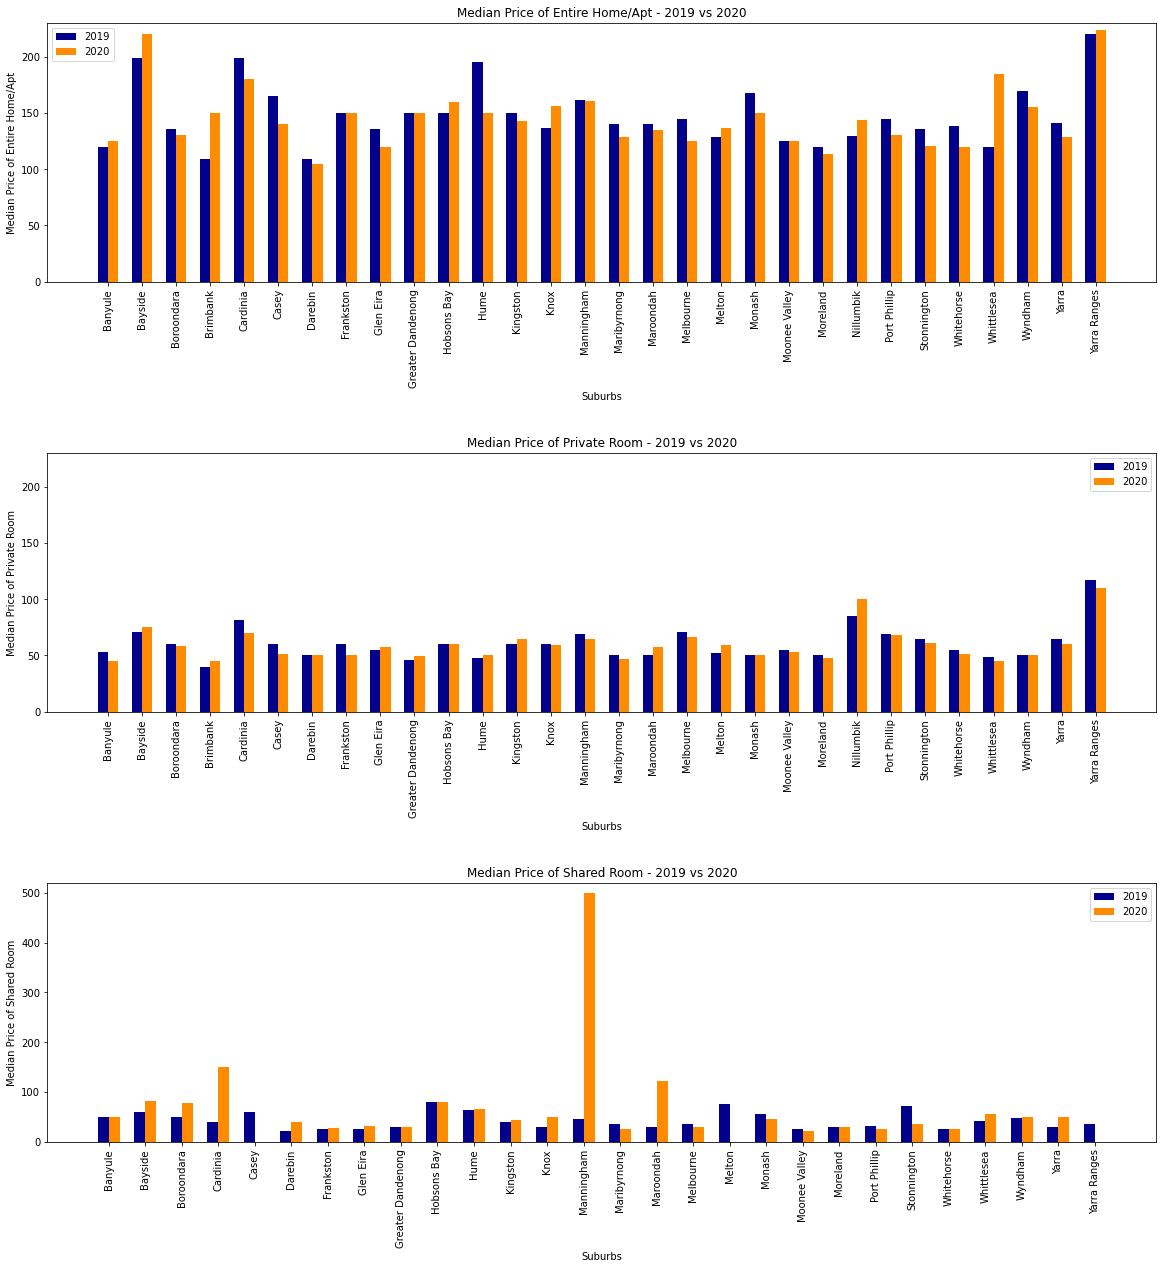

In [71]:
# Plotting price for each type of room type for 2019 vs 2020
# Numbers of pairs of bars for Entire Home and Private Rooms
N = 30

# Position of bars on x-axis for Entire Home and Private Rooms
position = np.arange(N)

# Numbers of pairs of bars for Shared Rooms
N_shared = 28

# Position of bars on x-axis for shared rooms
position_shared = np.arange(N_shared)

fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(20,20))
fig. tight_layout(pad=15.0)
ax1.bar(position, entire_group2019['price'] , width, label='2019', color='darkblue')
ax1.bar(position + width, entire_group2020['price'], width, label='2020', color='darkorange')

ax1.set_xlabel('Suburbs')
ax1.set_ylabel('Median Price of Entire Home/Apt')
ax1.set_title('Median Price of Entire Home/Apt - 2019 vs 2020')
ax1.set_xticks(position + width / 2)
ax1.set_xticklabels(entire_group2019['city'], rotation='vertical', fontsize=10)
ax1.set_ylim(0, 230)
ax1.legend(loc='best')

ax2.bar(position, private_group2019['price'] , width, label='2019', color='darkblue')
ax2.bar(position + width, private_group2020['price'], width, label='2020', color='darkorange')
ax2.set_xlabel('Suburbs')
ax2.set_ylabel('Median Price of Private Room')
ax2.set_title('Median Price of Private Room - 2019 vs 2020')
ax2.set_xticks(position + width / 2)
ax2.set_xticklabels(entire_group2019['city'], rotation='vertical', fontsize=10)
ax2.set_ylim(0, 230)
ax2.legend(loc='best')

ax3.bar(position_shared, shared_merge['price_2019'] , width, label='2019', color='darkblue')
ax3.bar(position_shared + width, shared_merge['price_2020'], width, label='2020', color='darkorange')
ax3.set_xlabel('Suburbs')
ax3.set_ylabel('Median Price of Shared Room')
ax3.set_title('Median Price of Shared Room - 2019 vs 2020')
ax3.set_xticks(position_shared + width / 2)
ax3.set_xticklabels(shared_merge['city'], rotation='vertical', fontsize=10)
ax3.set_ylim(0, 520)
ax3.legend(loc='best')

plt.savefig('output_files/Roomtype_price.png');


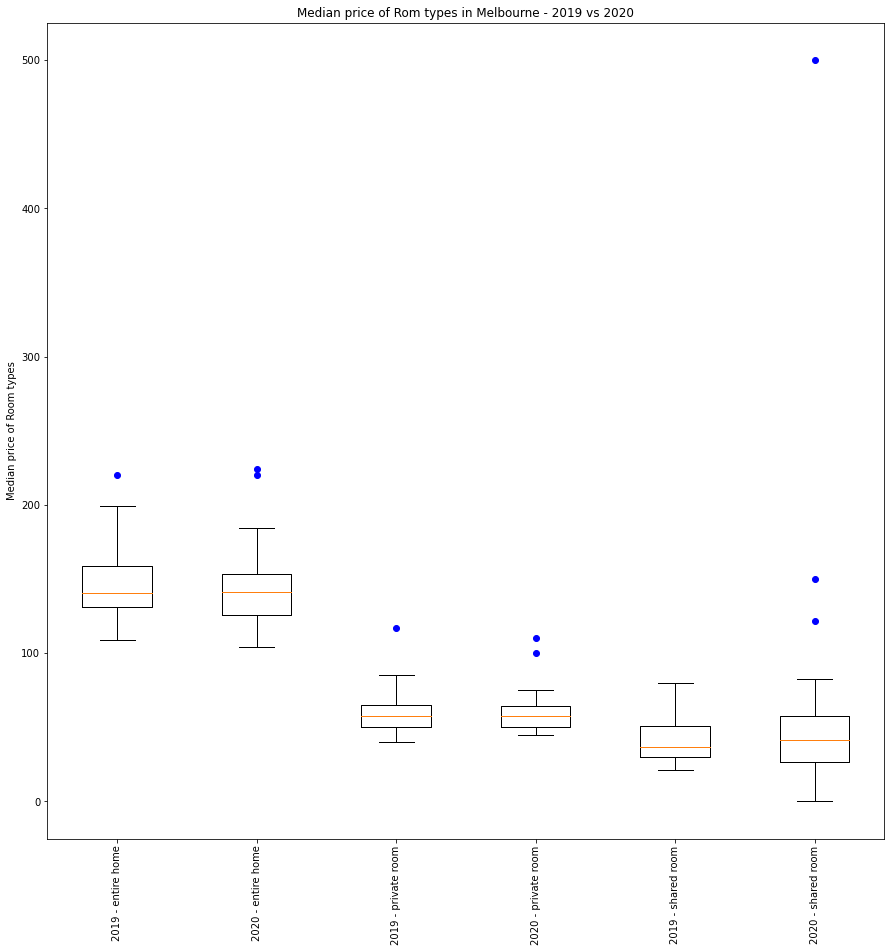

In [121]:
fig1, ax1 = plt.subplots(figsize=(15,15))
ax1.boxplot([entire_group2019['price'], entire_group2020['price'], private_group2019['price'], private_group2020['price'],
             shared_merge['price_2019'], shared_merge['price_2020']], sym ='bo')
ax1.set_xticklabels(['2019 - entire home', '2020 - entire home', '2019 - private room', '2020 - private room',
                    '2019 - shared room', '2020 - shared room'], rotation = 'vertical')
ax1.set_ylabel('Median price of Room types')
ax1.set_title('Median price of Rom types in Melbourne - 2019 vs 2020')
plt.savefig('output_files/Boxplot_medianprice.png');

### Plotting the number of room types in suburbs for 2019 vs 2020

In [72]:
# Plotting Room types for 2019 for suburbs
# 2019 data grouping by city
city_group2019 = list_2019.groupby('city')
city_group2019 = city_group2019['room_type'].value_counts().unstack()
city_group2019 = city_group2019.reset_index()
city_group2019.head()

room_type,city,Entire home/apt,Private room,Shared room
0,Banyule,105.0,93.0,5.0
1,Bayside,260.0,108.0,7.0
2,Boroondara,339.0,313.0,12.0
3,Brimbank,29.0,79.0,NaN
4,Cardinia,74.0,48.0,1.0


In [73]:
# Plotting number of room types in suburbs for 2020
# 2020 data grouping by city
city_group2020 = list_2020.groupby('city')
city_group2020 = city_group2020['room_type'].value_counts().unstack().fillna(0)
city_group2020 = city_group2020.reset_index()
city_group2020.head()

room_type,city,Entire home/apt,Hotel room,Private room,Shared room
0,Banyule,106.0,0.0,111.0,5.0
1,Bayside,253.0,1.0,101.0,2.0
2,Boroondara,294.0,10.0,272.0,8.0
3,Brimbank,46.0,0.0,103.0,0.0
4,Cardinia,79.0,1.0,58.0,1.0


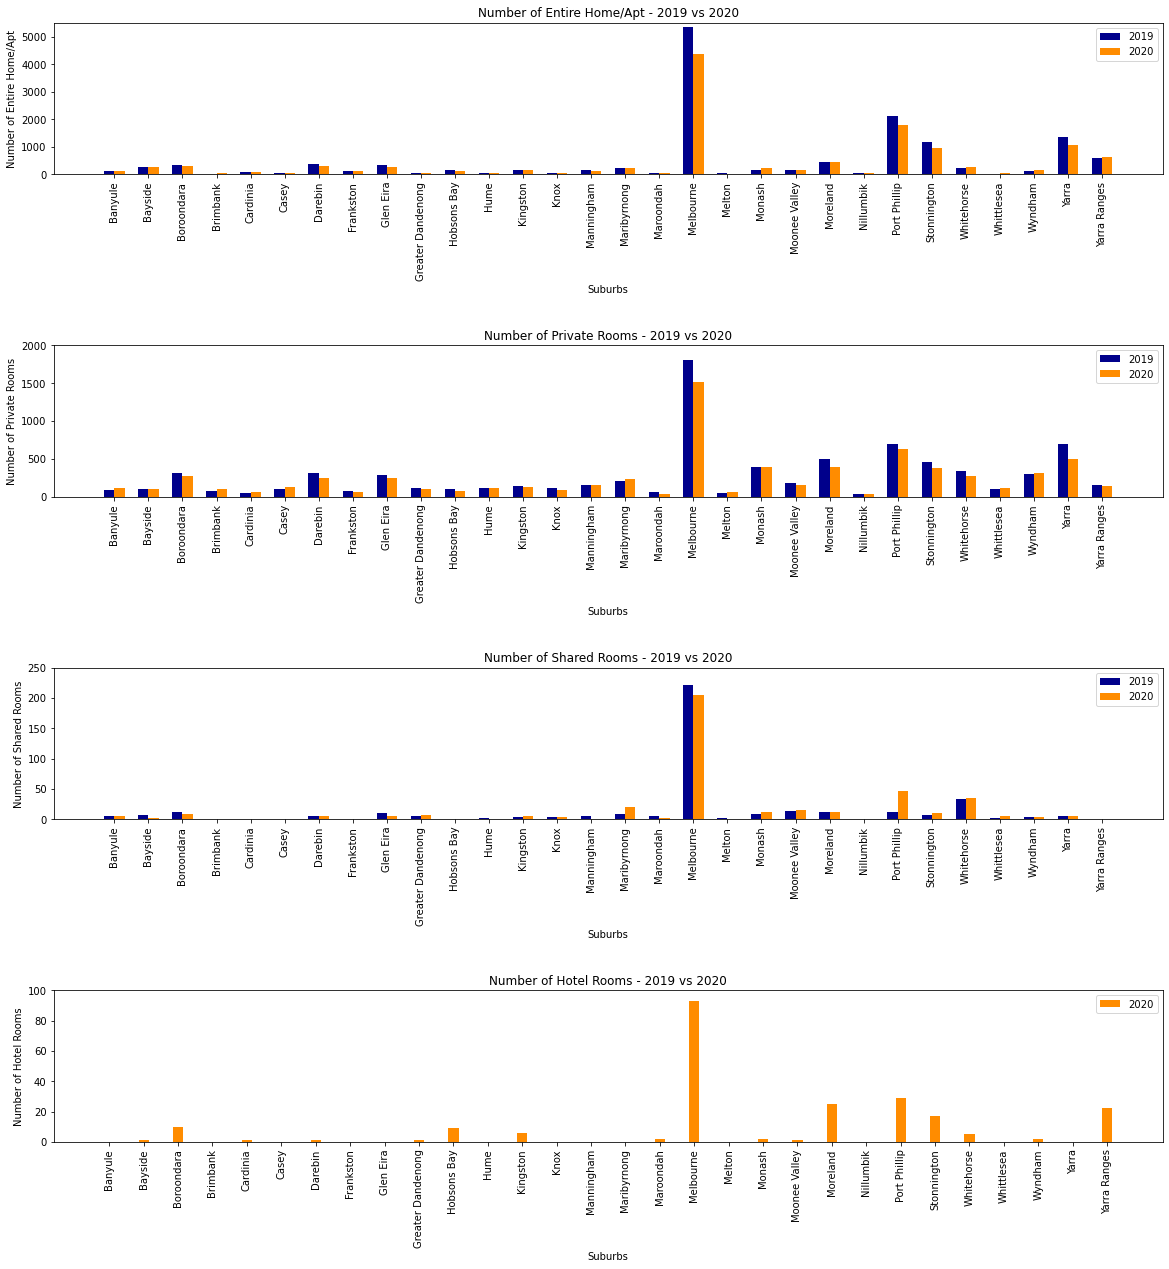

In [74]:
# Plotting number of room types in suburbs for 2020
# Numbers of pairs of bars for Suburbs
N = 30

# Position of bars on x-axis for Suburbs
position = np.arange(N)

width = 0.3

# ax1  subplot - Entire home/apt
# ax2  subplot - Private room
# ax3  subplot - Shared room
# ax1  subplot - Hotel Room
fig, (ax1,ax2, ax3, ax4 ) = plt.subplots(4,1, figsize=(20,20))
fig.tight_layout(pad=15.0)

ax1.bar(position, city_group2019['Entire home/apt'] , width, label='2019', color='darkblue')
ax1.bar(position + width, city_group2020['Entire home/apt'], width, label='2020', color='darkorange')

ax1.set_xlabel('Suburbs')
ax1.set_ylabel('Number of Entire Home/Apt')
ax1.set_title('Number of Entire Home/Apt - 2019 vs 2020')
ax1.set_xticks(position + width / 2)
ax1.set_xticklabels(city_group2019['city'], rotation='vertical', fontsize=10)
ax1.set_ylim(0, 5500)
ax1.legend(loc='best')

ax2.bar(position, city_group2019['Private room'], width, label='2019', color='darkblue')
ax2.bar(position + width, city_group2020['Private room'], width, label='2020', color='darkorange')
ax2.set_xlabel('Suburbs')
ax2.set_ylabel('Number of Private Rooms')
ax2.set_title('Number of Private Rooms - 2019 vs 2020')
ax2.set_xticks(position + width / 2)
ax2.set_xticklabels(city_group2019['city'], rotation='vertical', fontsize=10)
ax2.set_ylim(0, 2000)
ax2.legend(loc='best')

ax3.bar(position, city_group2019['Shared room'] , width, label='2019', color='darkblue')
ax3.bar(position + width, city_group2020['Shared room'], width, label='2020', color='darkorange')
ax3.set_xlabel('Suburbs')
ax3.set_ylabel('Number of Shared Rooms')
ax3.set_title('Number of Shared Rooms - 2019 vs 2020')
ax3.set_xticks(position + width / 2)
ax3.set_xticklabels(city_group2019['city'], rotation='vertical', fontsize=10)
ax3.set_ylim(0, 250)
ax3.legend(loc='best')

ax4.bar(position, city_group2020['Hotel room'], width, label='2020', color='darkorange')
ax4.set_xlabel('Suburbs')
ax4.set_ylabel('Number of Hotel Rooms')
ax4.set_title('Number of Hotel Rooms - 2019 vs 2020')
ax4.set_xticks(position)
ax4.set_xticklabels(city_group2019['city'], rotation='vertical', fontsize=10)
ax4.set_ylim(0, 100)
ax4.legend(loc='best')

plt.savefig('output_files/roomtypes_suburb.png');

In [75]:
merge_room_df = pd.merge(city_group2019, city_group2020, on = 'city', suffixes=('_2019', '_2020'))
merge_room_df = merge_room_df[['city', 'Entire home/apt_2019', 'Private room_2019', 'Shared room_2019', 'Entire home/apt_2020',
                               'Private room_2020', 'Shared room_2020', 'Hotel room']].fillna(0)
merge_room_df_list = merge_room_df.values.tolist()

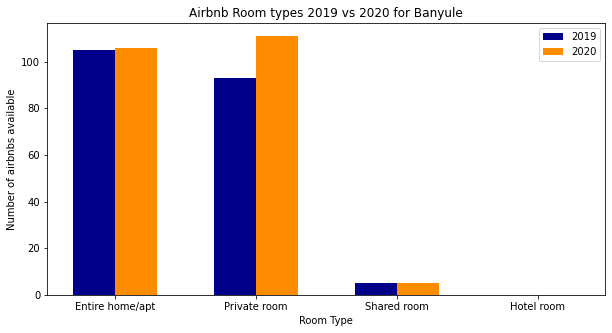

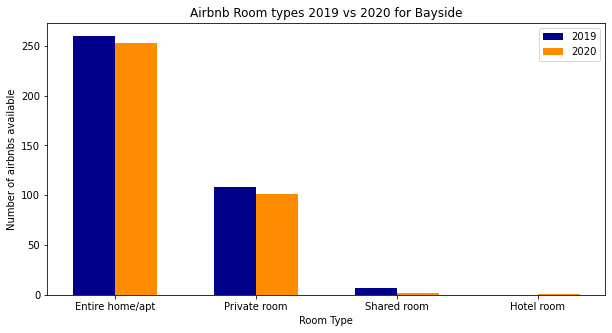

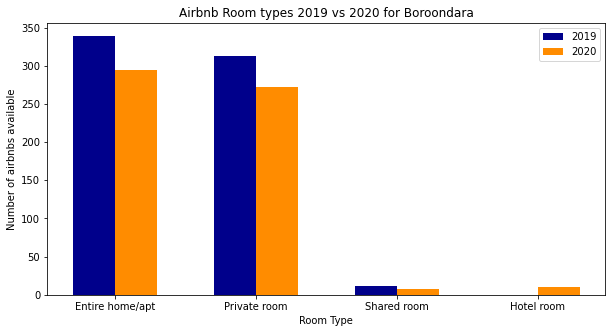

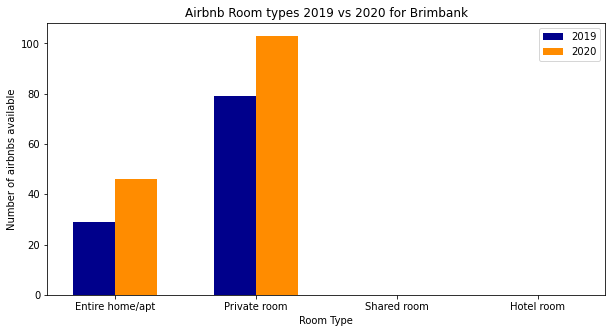

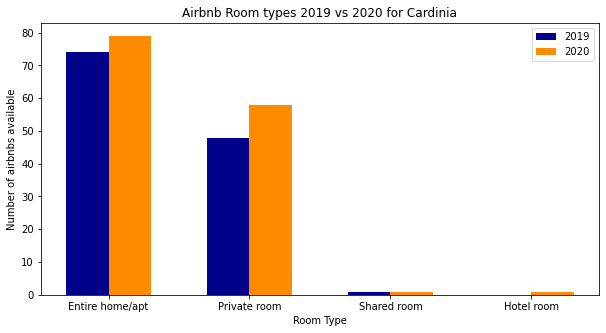

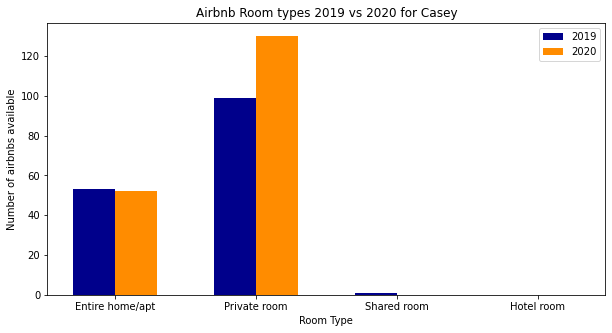

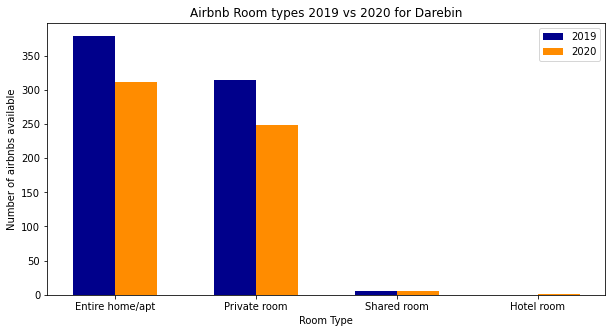

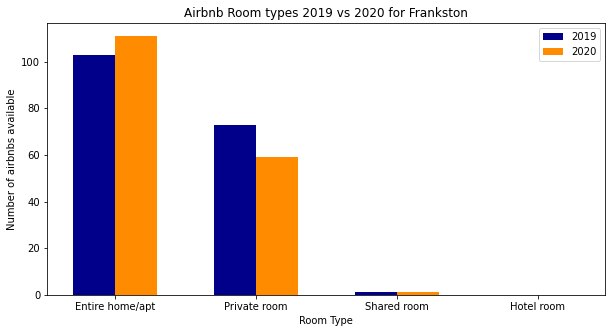

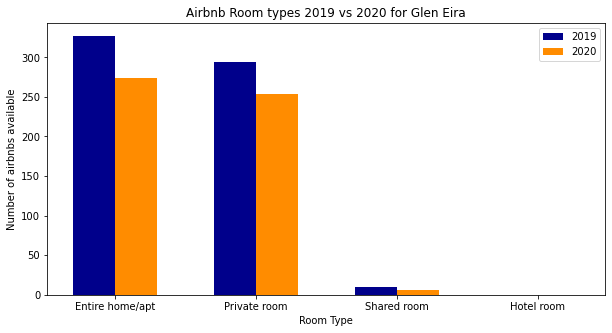

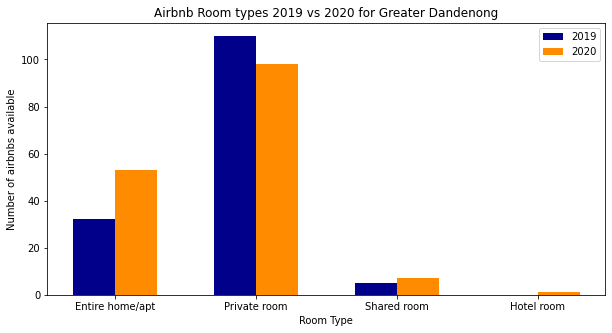

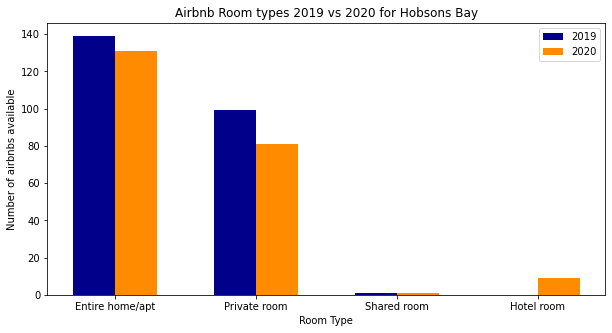

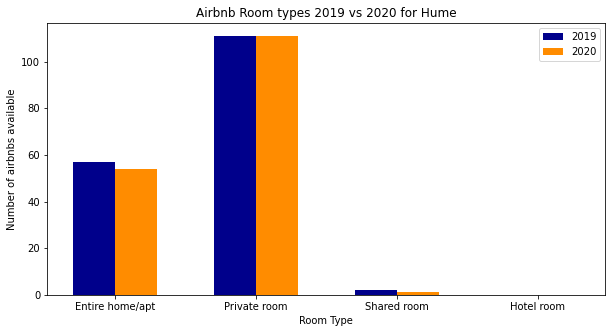

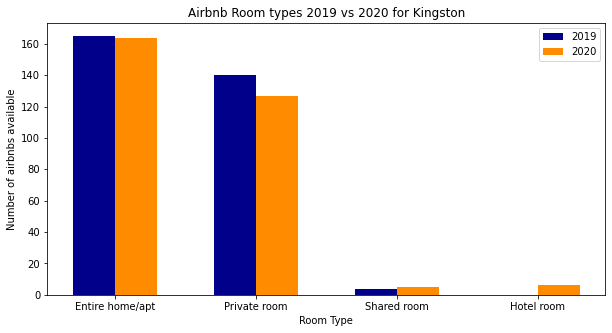

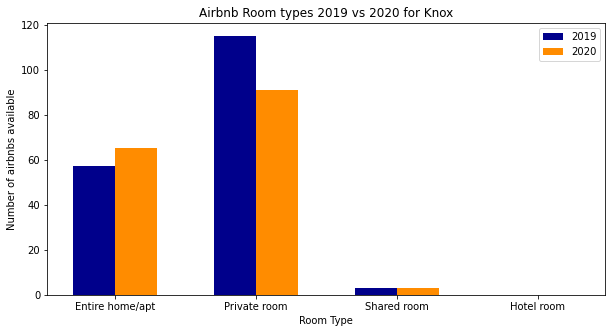

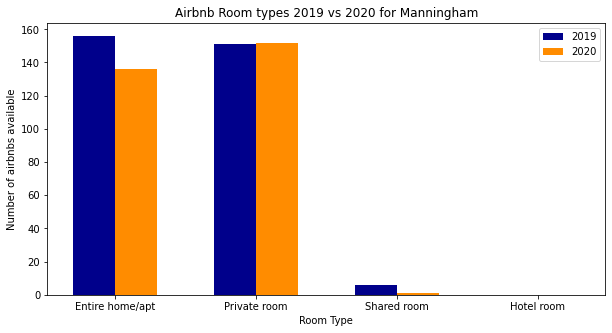

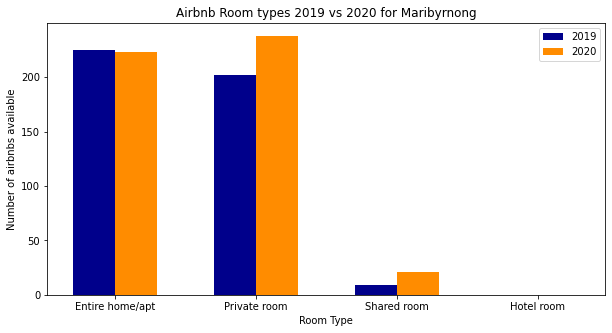

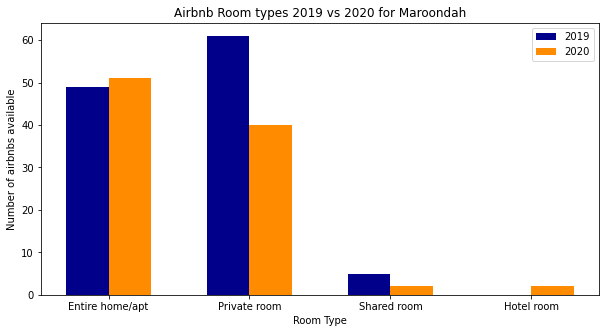

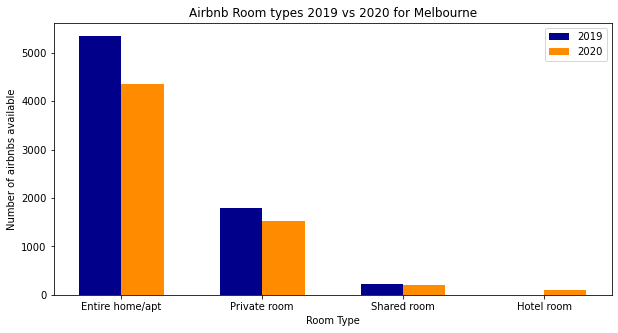

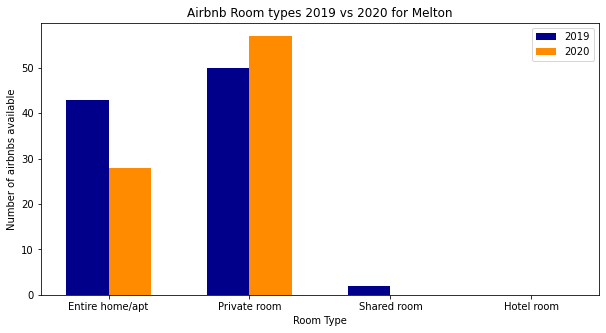

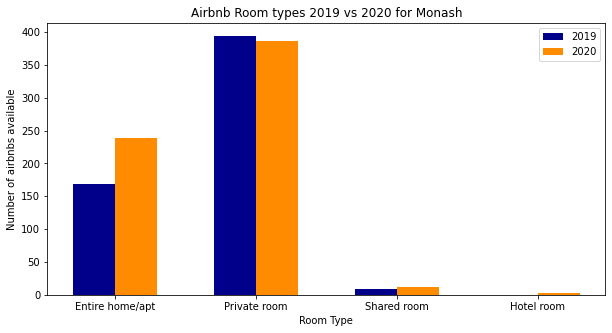

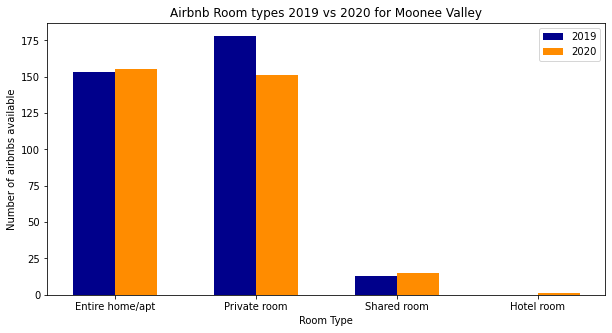

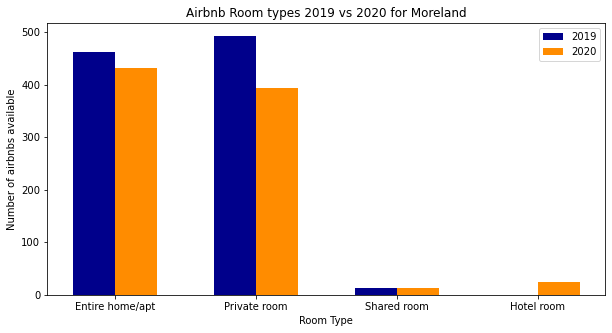

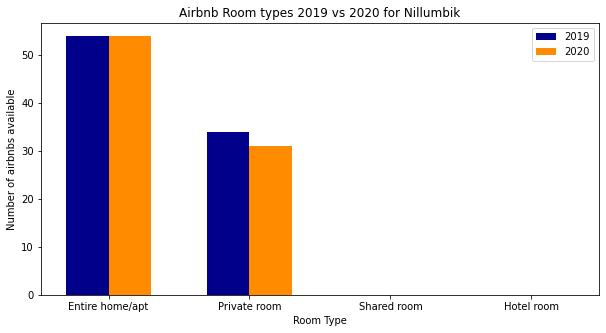

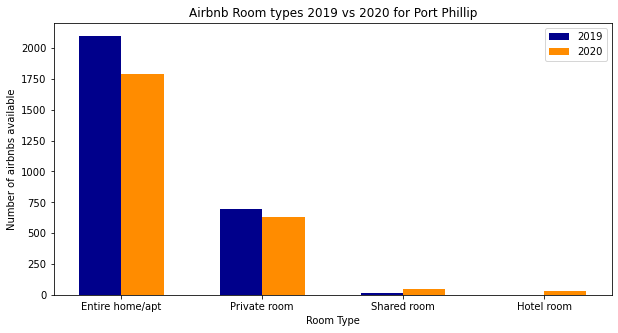

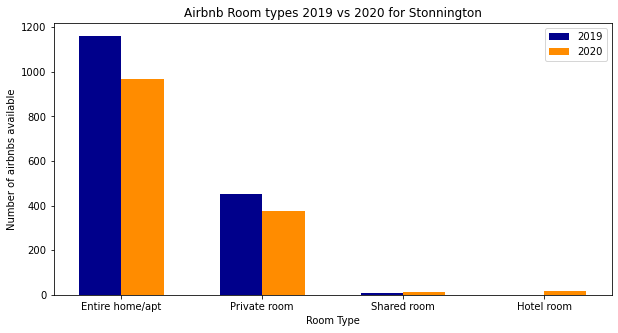

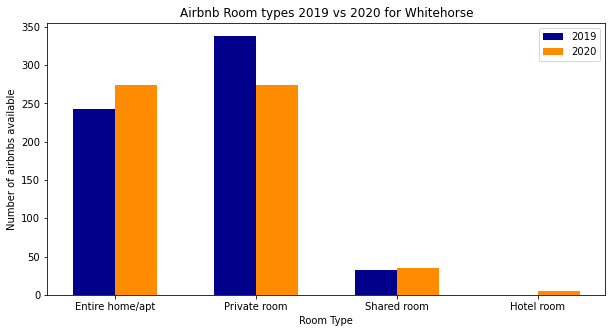

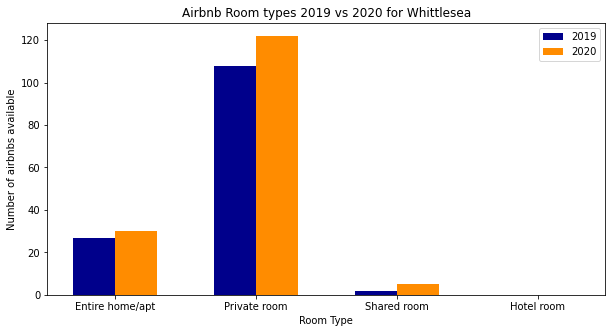

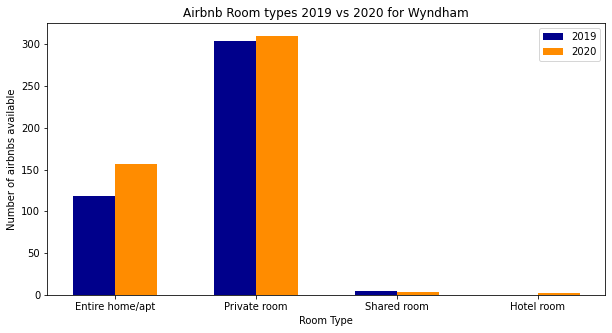

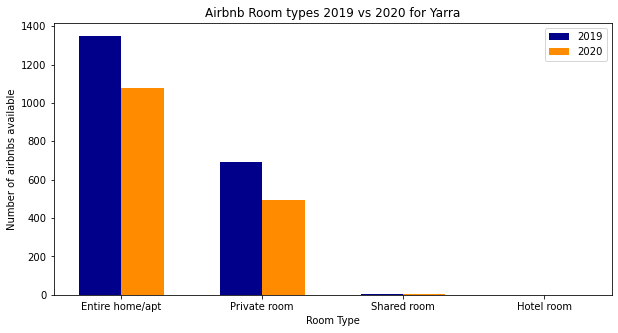

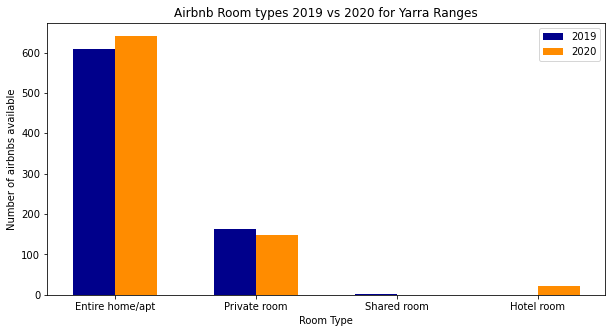

In [123]:
# Individual plots for each suburb
plt.rcParams.update({'figure.max_open_warning': 0})

xtick_value = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

for k in range(len(merge_room_df_list)):
    
    # Position of bars on x-axis
    position = np.arange(1,5,1)

    plt.figure(figsize=(10,5))

    # Width of a bar 
    width = 0.3       

    # Plotting
    plt.bar(1, merge_room_df_list[k][1] , width, label='2019', color='darkblue')
    plt.bar(1 + width, merge_room_df_list[k][4], width, label='2020', color='darkorange')
    
    plt.bar(2, merge_room_df_list[k][2] , width, color='darkblue')
    plt.bar(2 + width, merge_room_df_list[k][5], width, color='darkorange')
    
    plt.bar(3, merge_room_df_list[k][3] , width, color='darkblue')
    plt.bar(3 + width, merge_room_df_list[k][6], width, color='darkorange')
    
    plt.bar(4, 0 , width, color='darkblue')
    plt.bar(4 + width, merge_room_df_list[k][7], width, color='darkorange')

    plt.xlabel('Room Type')
    plt.ylabel('Number of airbnbs available')
    plt.title(f'Airbnb Room types 2019 vs 2020 for {merge_room_df_list[k][0]}')

    plt.xticks(position + (width/2), xtick_value)

    plt.legend(loc='best')
    file_name = f"output_files/Suburb Independent Plots/Output_Pie_{merge_room_df_list[k][0]}.png"
    plt.savefig(file_name)
    plt.show()
    

### Correlation between Review Score Rating and Price per Night in 2019

The r value is: 0.04


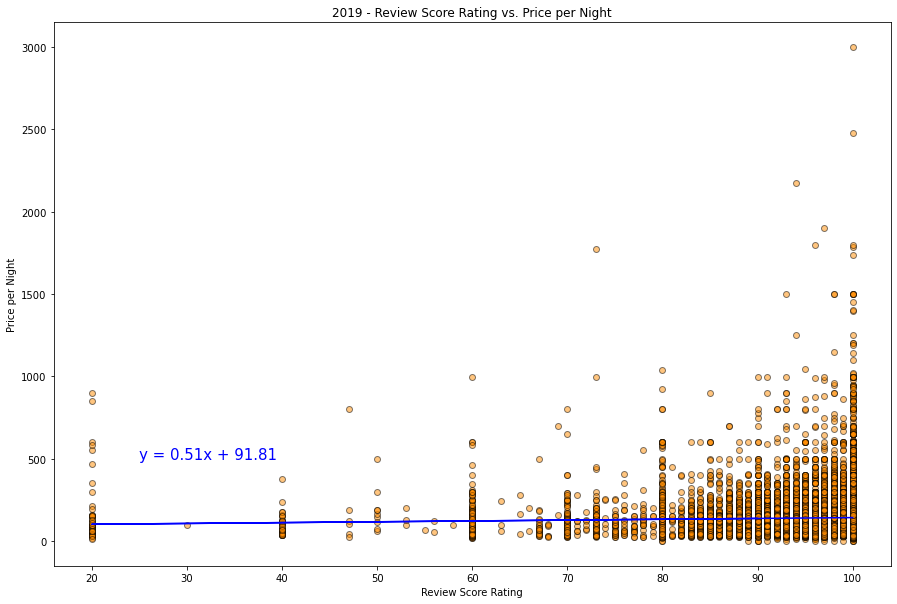

In [77]:
price_rate_2019 = list_2019[["price", "review_scores_rating"]]
clean_price_rate_2019 = price_rate_2019.dropna()

x_values = clean_price_rate_2019["review_scores_rating"]
y_values = clean_price_rate_2019["price"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(25,500),fontsize=15,color="blue")
plt.xlabel('Review Score Rating')
plt.ylabel('Price per Night')
plt.title("2019 - Review Score Rating vs. Price per Night")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2019_ReviewScore_vs_Price")
plt.show()

### Correlation between Review Score Rating and Price per Night in 2020

The r value is: 0.03


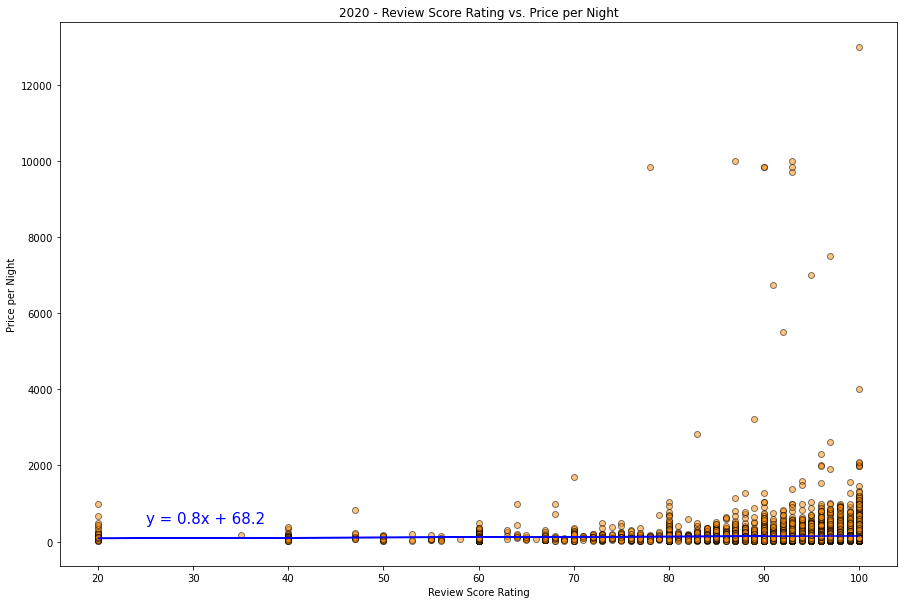

In [78]:
price_rate_2020 = list_2020[["price", "review_scores_rating"]]
clean_price_rate_2020 = price_rate_2020.dropna()

x_values = clean_price_rate_2020["review_scores_rating"]
y_values = clean_price_rate_2020["price"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(25,500),fontsize=15,color="blue")
plt.xlabel('Review Score Rating')
plt.ylabel('Price per Night')
plt.title("2020 - Review Score Rating vs. Price per Night")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2020_ReviewScore_vs_Price")
plt.show()

### Correlation between Number of Days Booked and Price per Night in 2019

In [79]:
#Finding all booked listing_id's and number of days booked
list_2019_price = list_2019[['listing_id','price','city']]
booked_2019 = cal_2019.loc[cal_2019['available'] == 'f']
booked_2019 = booked_2019.groupby('listing_id').count()
booked_2019 = pd.merge(booked_2019, list_2019_price, on = 'listing_id', how = 'left')
booked_2019 = booked_2019.rename(columns = {'available':'Number of Days Booked',
                                          'price_y': 'Price per Night'})
booked_2019 = booked_2019[['listing_id','Number of Days Booked','Price per Night', 'city']]
booked_2019.head()

,listing_id,Number of Days Booked,Price per Night,city
0,10803,152,35,Moreland
1,12936,39,159,Port Phillip
2,15246,365,50,Darebin
3,16760,37,69,Port Phillip
4,38271,37,98,Casey


The r value is: -0.11


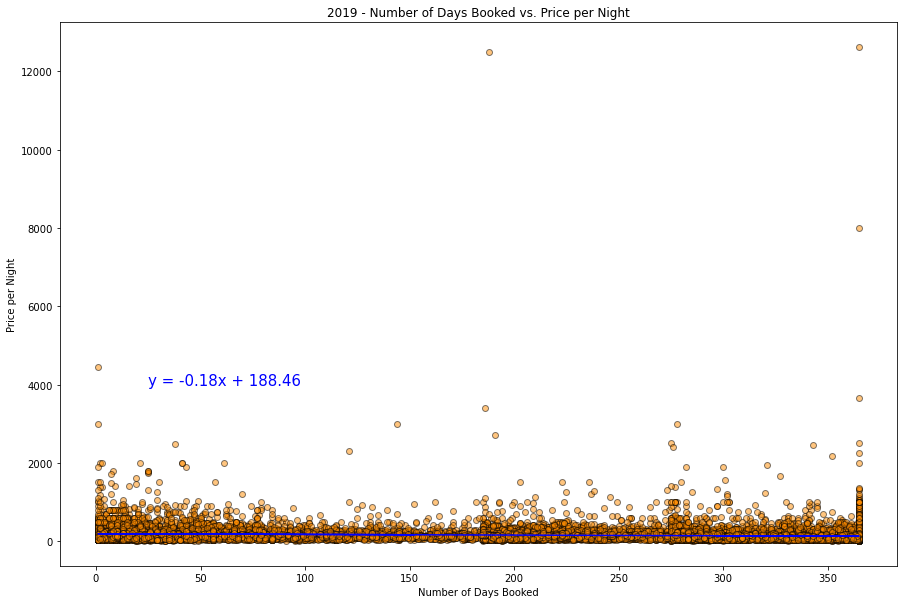

In [80]:
x_values = booked_2019["Number of Days Booked"]
y_values = booked_2019["Price per Night"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(25,4000),fontsize=15,color="blue")
plt.xlabel('Number of Days Booked')
plt.ylabel('Price per Night')
plt.title("2019 - Number of Days Booked vs. Price per Night")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2019_DaysBooked_vs_Price")
plt.show()

### Correlation between Number of Days Booked and Price per Night in 2020

In [81]:
#Finding all booked listing_id's and number of days booked
list_2020_price = list_2020[['listing_id','price','city']]
booked_2020 = cal_2020.loc[cal_2020['available'] == 'f']
booked_2020 = booked_2020.groupby('listing_id').count()
booked_2020 = pd.merge(booked_2020, list_2020_price, on = 'listing_id', how = 'left')
booked_2020 = booked_2020.rename(columns = {'available':'Number of Days Booked',
                                          'price_y': 'Price per Night'})
booked_2020 = booked_2020[['listing_id','Number of Days Booked','Price per Night', 'city']]
booked_2020.head()

,listing_id,Number of Days Booked,Price per Night,city
0,10803,364,31.0,Moreland
1,12936,365,95.0,Port Phillip
2,38271,36,99.0,Casey
3,41836,367,40.0,Darebin
4,43429,18,99.0,Monash


The r value is: -0.04


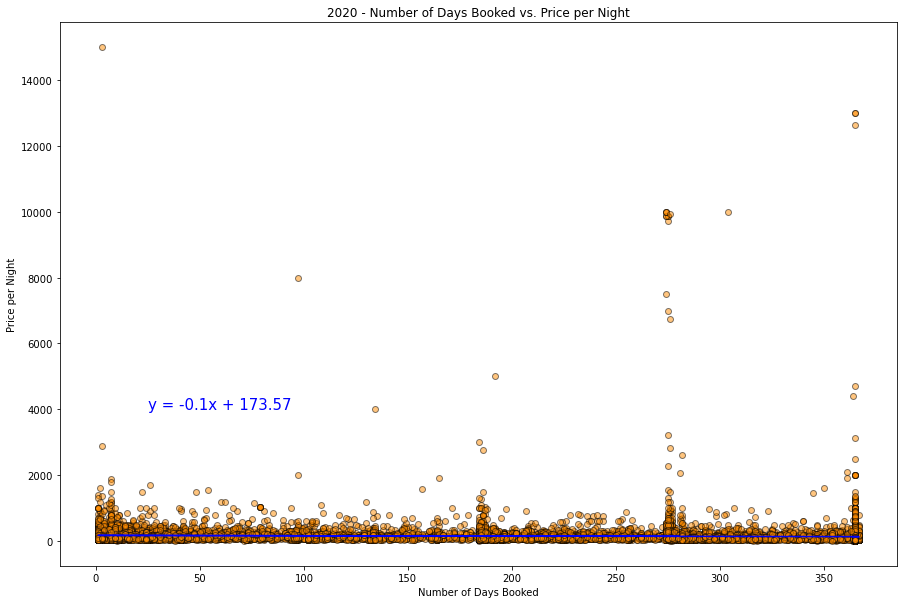

In [82]:
x_values = booked_2020["Number of Days Booked"]
y_values = booked_2020["Price per Night"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(25,4000),fontsize=15,color="blue")
plt.xlabel('Number of Days Booked')
plt.ylabel('Price per Night')
plt.title("2020 - Number of Days Booked vs. Price per Night")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2020_DaysBooked_vs_Price")
plt.show()

### Correlation between Number of Days Booked and Host Response Rate in 2019

The r value is: -0.34


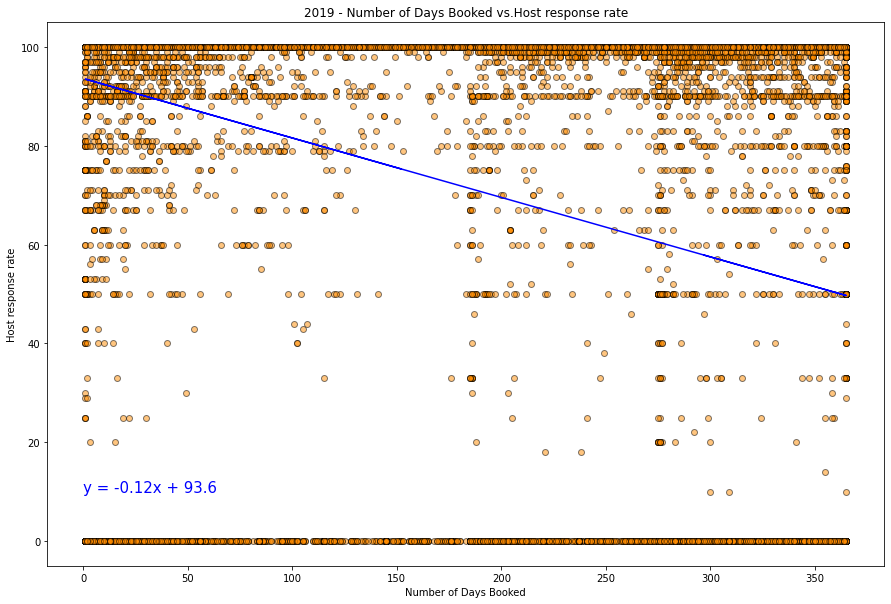

In [83]:
resp_rate_days_2019 = list_2019[["listing_id","host_response_rate"]]

resp_rate_days_2019 = pd.merge(resp_rate_days_2019, booked_2019, on = 'listing_id', how = 'right')

resp_rate_days_2019.fillna(value=0,inplace=True)

resp_rate_days_2019['host_response_rate'] = resp_rate_days_2019['host_response_rate'].replace('%', '', regex=True).astype(int)


x_values = resp_rate_days_2019["Number of Days Booked"]
y_values = resp_rate_days_2019["host_response_rate"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(0,10),fontsize=15,color="blue")
plt.xlabel('Number of Days Booked')
plt.ylabel('Host response rate')
plt.title("2019 - Number of Days Booked vs.Host response rate")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2019_DaysBooked_vs_HostResponseRate")
plt.show()

### Correlation between Number of Days Booked and Host Response Rate in 2020

The r value is: -0.4


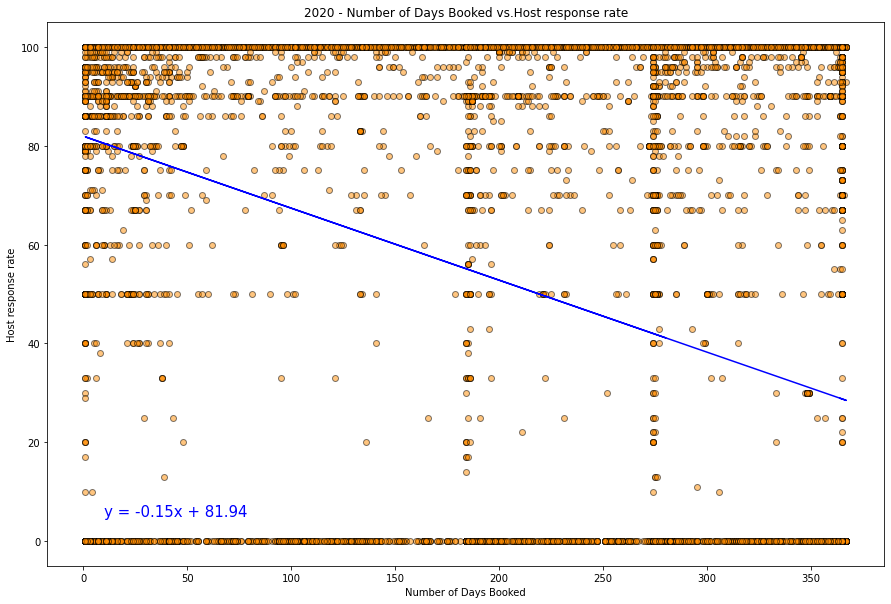

In [84]:
resp_time_days_2020 = list_2020[["listing_id","host_response_rate"]]

resp_time_days_2020 = pd.merge(resp_time_days_2020, booked_2020, on = 'listing_id', how = 'right')

resp_time_days_2020.fillna(value=0,inplace=True)

resp_time_days_2020['host_response_rate'] = resp_time_days_2020['host_response_rate'].replace('%', '', regex=True).astype(int)


x_values = resp_time_days_2020["Number of Days Booked"]
y_values = resp_time_days_2020["host_response_rate"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(15,10))
plt.scatter(x_values,y_values, facecolor = 'darkorange', edgecolor = 'black', alpha = 0.5)
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(10,5),fontsize=15,color="blue")
plt.xlabel('Number of Days Booked')
plt.ylabel('Host response rate')
plt.title("2020 - Number of Days Booked vs.Host response rate")
print(f"The r value is: {round(rvalue,2)}")
plt.savefig("output_files/2020_DaysBooked_vs_HostResponseRate")
plt.show()

### Comparison between Room Type and Mean Number of Days booked in 2019 & 2020

In [85]:
prop_type_days_2019 = list_2019[["listing_id","room_type"]]
prop_type_days_2019 = pd.merge(prop_type_days_2019, booked_2019, on = 'listing_id', how = 'right')

smry_prop_type_days_2019 = prop_type_days_2019.groupby("room_type").mean()
smry_prop_type_days_2019.sort_values("Number of Days Booked", ascending=False, inplace=True)
smry_prop_type_days_2019

,listing_id,Number of Days Booked,Price per Night
room_type,,,
Shared room,2.125083e+07,278.941176,48.147059
Private room,1.890974e+07,251.235799,76.290394
Entire home/apt,1.862952e+07,226.121845,187.818003


In [86]:
prop_type_days_2020 = list_2020[["listing_id","room_type"]]
prop_type_days_2020 = pd.merge(prop_type_days_2020, booked_2020, on = 'listing_id', how = 'right')

smry_prop_type_days_2020 = prop_type_days_2020.groupby("room_type").mean()
smry_prop_type_days_2020.sort_values("Number of Days Booked", ascending=False, inplace=True)
smry_prop_type_days_2020

,listing_id,Number of Days Booked,Price per Night
room_type,,,
Shared room,2.920812e+07,267.890141,54.963380
Private room,2.637645e+07,256.258458,87.843128
Entire home/apt,2.584060e+07,229.238128,184.287671
Hotel room,2.890528e+07,181.909091,215.285000


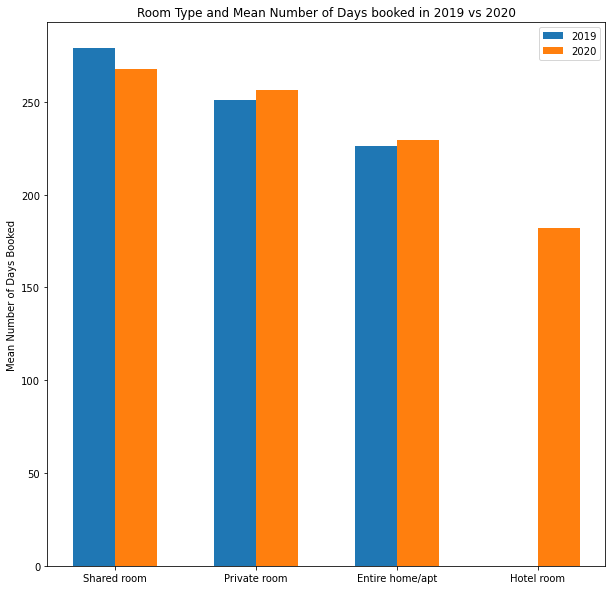

In [87]:
plt.figure(figsize=(10,10))
plt.bar(smry_prop_type_days_2019.index.values, smry_prop_type_days_2019["Number of Days Booked"], align='edge', width=-0.3, label="2019")
plt.bar(smry_prop_type_days_2020.index.values, smry_prop_type_days_2020["Number of Days Booked"], align='edge', width=0.3, label="2020")
plt.legend()
plt.ylabel("Mean Number of Days Booked")
plt.title("Room Type and Mean Number of Days booked in 2019 vs 2020")
plt.savefig("output_files/2020_2019_AvgDaysBooked_vs_RoomType")
plt.show()